In [2]:
# !pip install lightautoml
# !pip install category_encoders

In [26]:
import pandas as pd
import numpy as np
import typing
import torch
from tqdm import tqdm_notebook
from sklearn.model_selection import train_test_split
from category_encoders import CountEncoder
from matplotlib import pyplot as plt
import joblib

from lightautoml.automl.presets.tabular_presets import TabularUtilizedAutoML
from lightautoml.tasks import Task
%matplotlib inline

In [4]:
!git clone https://github.com/SlayZar/evr_hack_comp21.git

Cloning into 'evr_hack_comp21'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 81 (delta 31), reused 52 (delta 12), pack-reused 0
Unpacking objects: 100% (81/81), done.


In [27]:
df = pd.read_pickle('evr_hack_comp21/data/train_features')
test_df = pd.read_pickle('evr_hack_comp21/data/test_features')

In [52]:
not_fit = False # Если не хотим обучать, ставим True и не запускаем ячейки в группах "Модели..."

## EDA analisys

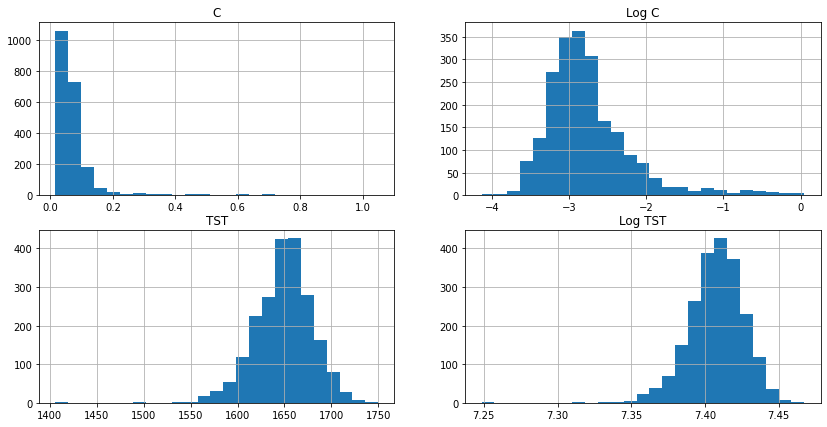

In [28]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14,7))

ax1.hist(df['C'], bins=25)
ax1.grid()
ax1.set_title('C')
ax2.hist(np.log(df['C']), bins=25)
ax2.grid()
ax2.set_title('Log C')
ax3.hist(df['TST'], bins=25)
ax3.grid()
ax3.set_title('TST')
ax4.hist(np.log(df['TST']), bins=25)
ax4.set_title('Log TST')
ax4.grid()
plt.show()

In [29]:
df['log_C'] = np.log(df['C'])
test_df['C'] = 0
test_df['TST'] = 0
test_df['log_C'] = 0

In [30]:
test_df.shape, df.shape

((780, 585), (2137, 585))

In [31]:
cat_features = ['lom_plavka_NMZ',	'lom_plavka_NAPR_ZAD', 'lom_plavka_TIPE_FUR', 'lom_plavka_TIPE_GOL']
dropcols = ['TST', 'C', 'NPLV', 'plavka_VR_NACH',	'plavka_VR_KON', 'log_C']

In [32]:
for col in cat_features:
    df['for_cnt_cat_' + col] = df[col].copy()
    test_df['for_cnt_cat_' + col] = test_df[col].copy()
ce = CountEncoder(cols=['for_cnt_cat_' + x for x in cat_features])
df = ce.fit_transform(df)
test_df = ce.transform(test_df)

In [41]:
N_THREADS = 4 # threads cnt for lgbm and linear models
N_FOLDS = 3 # folds cnt for AutoML
RANDOM_STATE = 42 # fixed random state for various reasons
TIMEOUT = 60 # Time in seconds for automl run USE TIMEOUT = 1700 for perfect score

np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [42]:
def metric1(answers, user_csv):
    delta_c = np.abs(answers - user_csv)
    hit_rate_c = np.int64(delta_c < 20)

    N = np.size(answers)

    return np.sum(hit_rate_c) / N
    
def metric2(answers, user_csv):
    delta_t = np.abs(np.array(answers) - np.array(user_csv))
    hit_rate_t = np.int64(delta_t < 0.02)

    N = np.size(answers)

    return np.sum(hit_rate_t) / N

In [43]:
new_cols = joblib.load('evr_hack_comp21/models/model_cols')

In [44]:
df.shape[1], len(new_cols)

(589, 286)

### Модель содержания углерода

In [45]:
task = Task('reg',  loss='mae', metric = metric2, greater_is_better=True)

roles = {
    'target': 'log_C',
    'drop': ['C', 'TST', 'NPLV', 'plavka_VR_NACH',	'plavka_VR_KON']
}
df=df[~df.C.isnull()]
automl2 = TabularUtilizedAutoML(task = task,
                               timeout = TIMEOUT,
                               cpu_limit = N_THREADS,
                               reader_params = {'n_jobs': N_THREADS,
                                                'cv': N_FOLDS,
                                                'random_state': RANDOM_STATE})

oof_pred = automl2.fit_predict(df[list(new_cols) + ['log_C', 'TST']], roles = roles)
output2 = pd.DataFrame({'NPLV': test_df['NPLV'],
                       'C': np.exp(automl2.predict(test_df[list(new_cols)]).data[:, 0])})

### Модель температуры чугуна

In [46]:
task = Task('reg', loss = 'rmsle', 
            metric = metric1, greater_is_better=True)

roles = {
    'target': 'TST',
    'drop': ['C', 'NPLV', 'plavka_VR_NACH',	'plavka_VR_KON']
}
automl = TabularUtilizedAutoML(task = task,
                               timeout = TIMEOUT,
                               cpu_limit = N_THREADS,
                               reader_params = {'n_jobs': N_THREADS,
                                                'cv': N_FOLDS,
                                                'random_state': RANDOM_STATE})

oof_pred = automl.fit_predict(df[list(new_cols) + ['TST', 'log_C']], roles = roles)

### Сабмит

In [53]:
if not_fit:
  automl = joblib.load('automl')
  automl2 = joblib.load('automl2')

In [54]:
test_df['log_C'] = automl2.predict(test_df[new_cols]).data[:, 0]

output = pd.DataFrame({'NPLV': test_df['NPLV'],
                       'TST': automl.predict(test_df[list(new_cols)+['log_C']]).data[:, 0]})

In [55]:
ss = pd.read_csv('evr_hack_comp21/data/sample_submission.csv')
ss.drop(['TST', 'C'], axis=1).merge(output, on =['NPLV']).merge(output2, on =['NPLV'])\
        .to_csv('lama_60_model_v2.csv', index=False)

In [ ]:
# joblib.dump(automl, 'evr_hack_comp21/models/automl')
# joblib.dump(automl2, 'evr_hack_comp21/models/automl2')